In [1]:
import os
import matplotlib.pyplot as plt
from rasterio.plot import show
import rasterio
import numpy as np
from IPython.display import display
os.chdir('/home/sarvagya/computer_vision')

In [2]:
def check_tiff_images(directory):
    channel_ct = {}
    for filename in os.listdir(directory):
        if filename.lower().endswith(".tiff") or filename.lower().endswith(".tif"):
            file_path = os.path.join(directory, filename)
            with rasterio.open(file_path) as img:
                # width, height = img.width, img.height
                n_channels = img.count
                channel_ct[n_channels] = channel_ct.get(n_channels, 0)+1
    print(channel_ct)
    return 
                
                
check_tiff_images('data/original_images')

{12: 100}


#### Plotting some train images


Metadata: {'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1065, 'height': 803, 'count': 12, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, 173.09170085751316,
       0.0, -8.983152841195215e-05, -41.29986552433817)}
Size: 1065x803


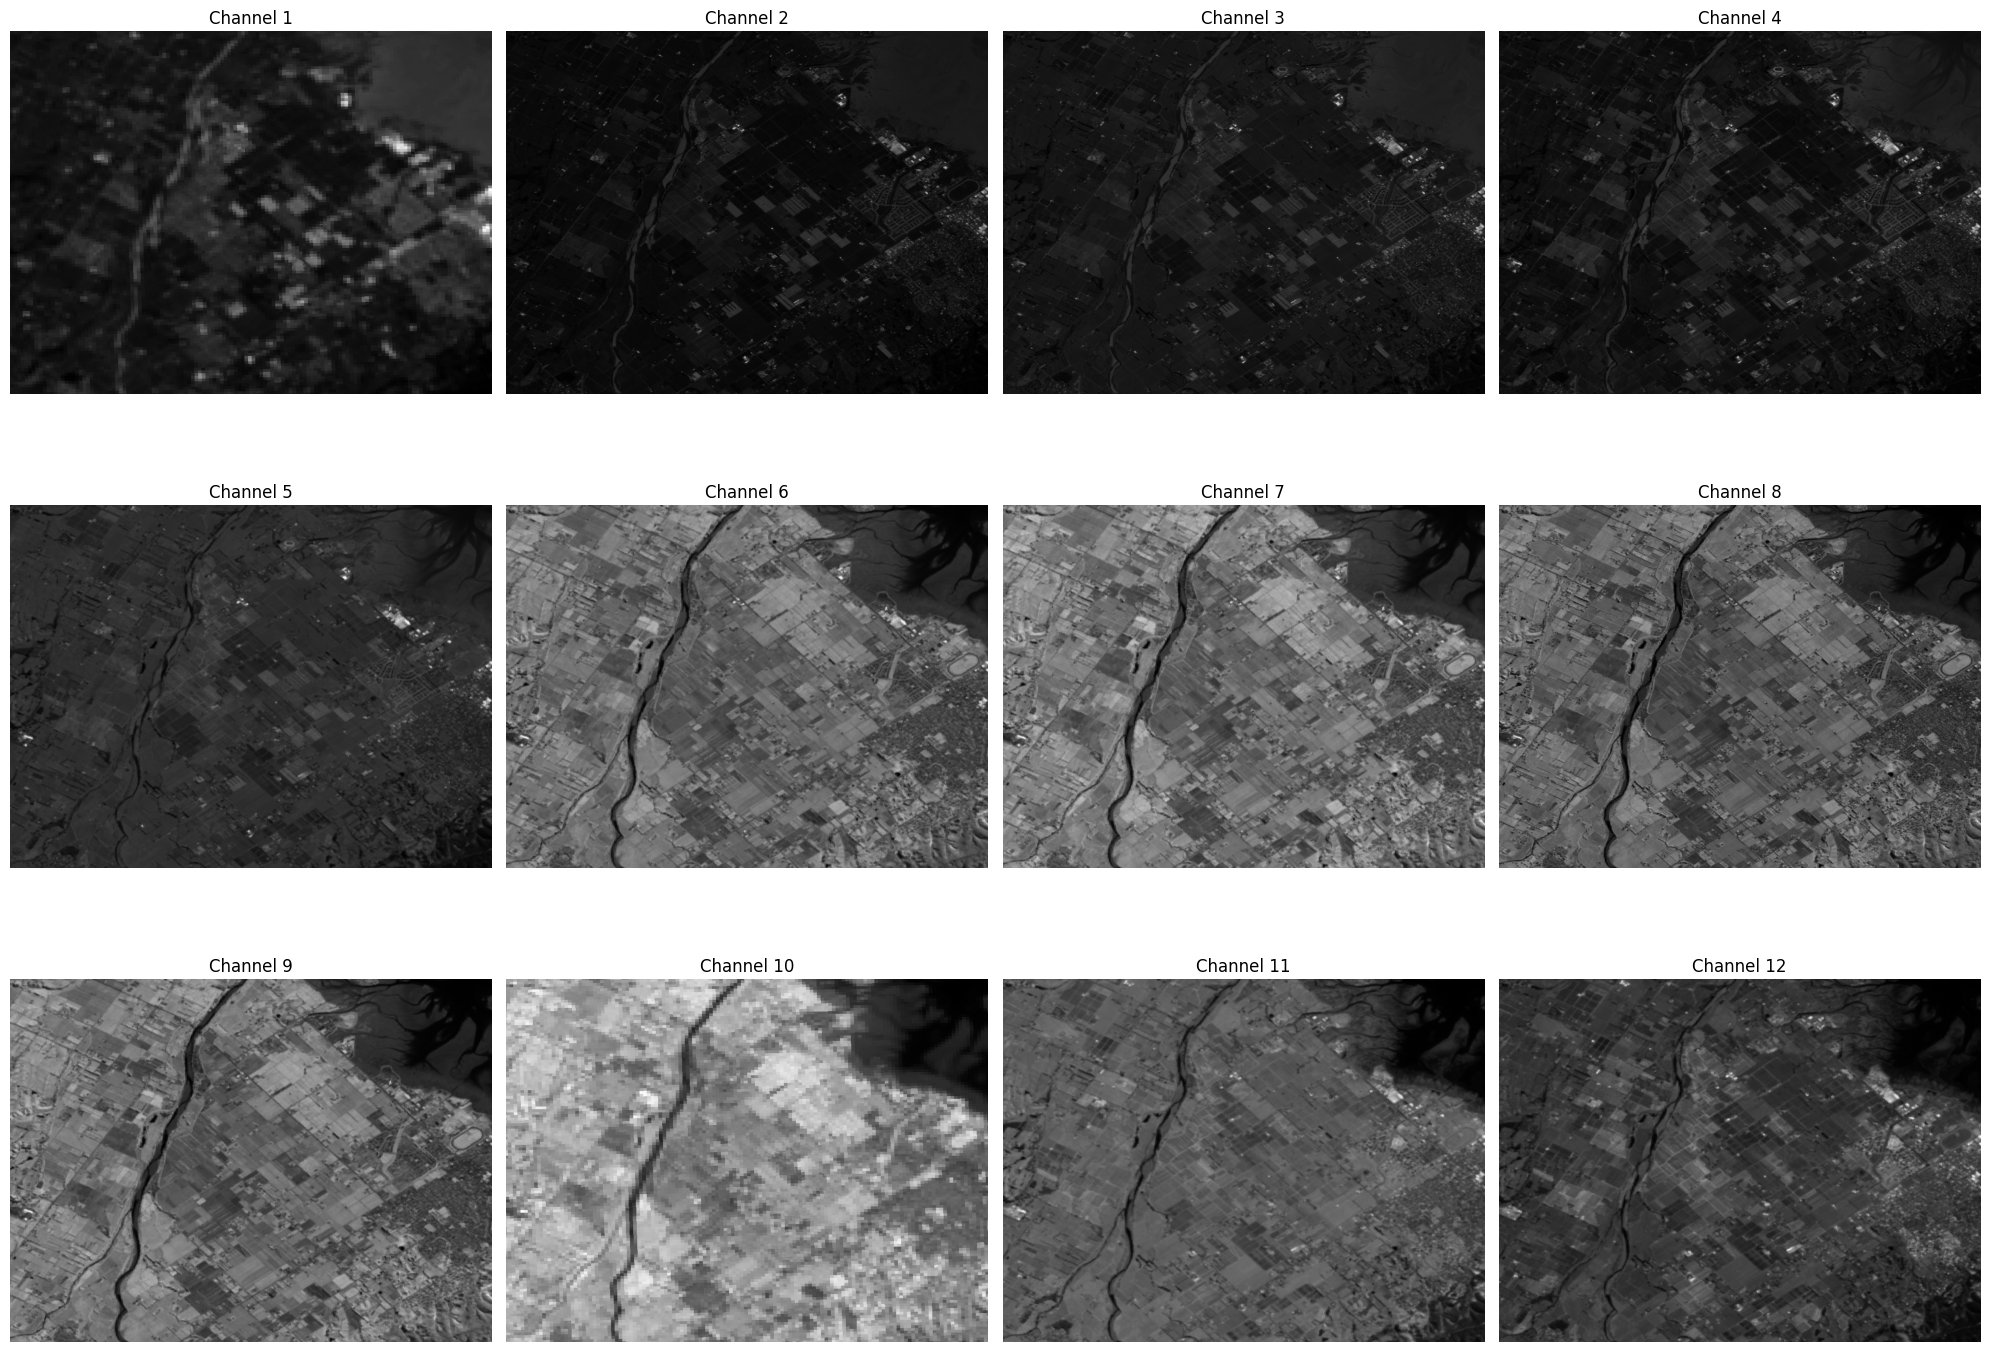

In [3]:
import rasterio
import matplotlib.pyplot as plt

image_num = 7
# Load the TIFF image using rasterio
file_path = f'data/original_images/train_{image_num}.tif'
with rasterio.open(file_path) as dataset:
    # Read the image data
    img_data = dataset.read()
    
    # Print metadata
    print("Metadata:", dataset.meta)
    
    # Dimensions
    width, height = dataset.width, dataset.height
    print(f"Size: {width}x{height}")

# Visualize each channel
fig, axes = plt.subplots(3, 4, figsize=(20, 15))  # Adjust subplot layout based on number of channels
axes = axes.flatten()
num_channels= 12
for i in range(num_channels):
    ax = axes[i]
    ax.imshow(img_data[i], cmap='gray')
    ax.set_title(f'Channel {i+1}')
    ax.axis('off')

# Hide any unused subplots
for j in range(num_channels, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [4]:
import json
from processing.img_preproc import *

image_num = 7

with open("data/train_annotation.json") as f:
  data = json.load(f)
  
file_path = f'data/original_images/train_{image_num}.tif'  
with rasterio.open(file_path) as dataset:
  img_data = dataset.read()[6]    # taking 5th channel
  bounds = dataset.bounds
  transform = dataset.transform
  image_crs = dataset.crs
  
json_data = data["images"][image_num]["annotations"]
geojson_data = convert_to_geojson(json_data, save_path='poli.json')  # Convert to GeoJSON
polygons = gpd.GeoDataFrame.from_features(geojson_data,  crs="EPSG:4326")

# Ensure the polygons have the same CRS as the image
if polygons.crs != image_crs:
  print(f"Image CRS: {image_crs}")
  print(f"Polygons CRS: {polygons.crs}")

  polygons = polygons.set_crs(image_crs, allow_override=True)

# display(polygons)

# Plot the image and polygons
fig, axs = plt.subplots(1,1 ,figsize=(20, 15))

axs.imshow(img_data, cmap='gray')

# Overlay the polygons on the TIFF image
for poly in polygons.loc[:, 'geometry']:
  x, y = poly.exterior.xy
  axs.plot(x, y, color='red')


plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


TypeError: NDFrame.to_csv() got an unexpected keyword argument 'driver'

(803, 1065)


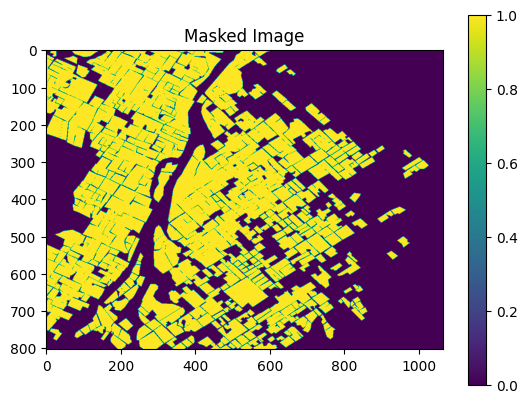

In [9]:
import cv2
from geopandas.geodataframe import GeoDataFrame

def create_mask_polygons(height:int, width:int , polygons:GeoDataFrame):
    mask = np.zeros((height, width))
    for i, poly in enumerate(polygons):
        poly = np.array(poly.exterior.coords)
        poly = np.array([[x, y] for x, y in poly], dtype=np.int32)
        mask = cv2.fillPoly(mask, [poly], color=1)
    # print(mask.shape)
    return mask

height, width = img_data.shape
masked_image = create_mask_polygons(height, width, polygons.loc[:, 'geometry'])
plt.imshow(masked_image)  # Assuming it's a grayscale image
plt.title('Masked Image')
plt.colorbar()  # Add color bar for grayscale images
plt.show()

In [1]:
import zipfile
import os

def unzip_file(zip_filepath, dest_dir):
    """
    Unzips a file to the specified destination directory.

    :param zip_filepath: Path to the zip file to be extracted.
    :param dest_dir: Directory where the zip file contents will be extracted.
    """
    # Ensure the destination directory exists
    os.makedirs(dest_dir, exist_ok=True)
    
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)
    print(f"Unzipped {zip_filepath} to {dest_dir}")

# # Example usage
# zip_filepath = 'data/EuroSAT_MS.zip'
# dest_dir = 'data'
# unzip_file(zip_filepath, dest_dir)


Unzipped data/EuroSAT_MS.zip to data


### Analysing the EuroSAT_MS

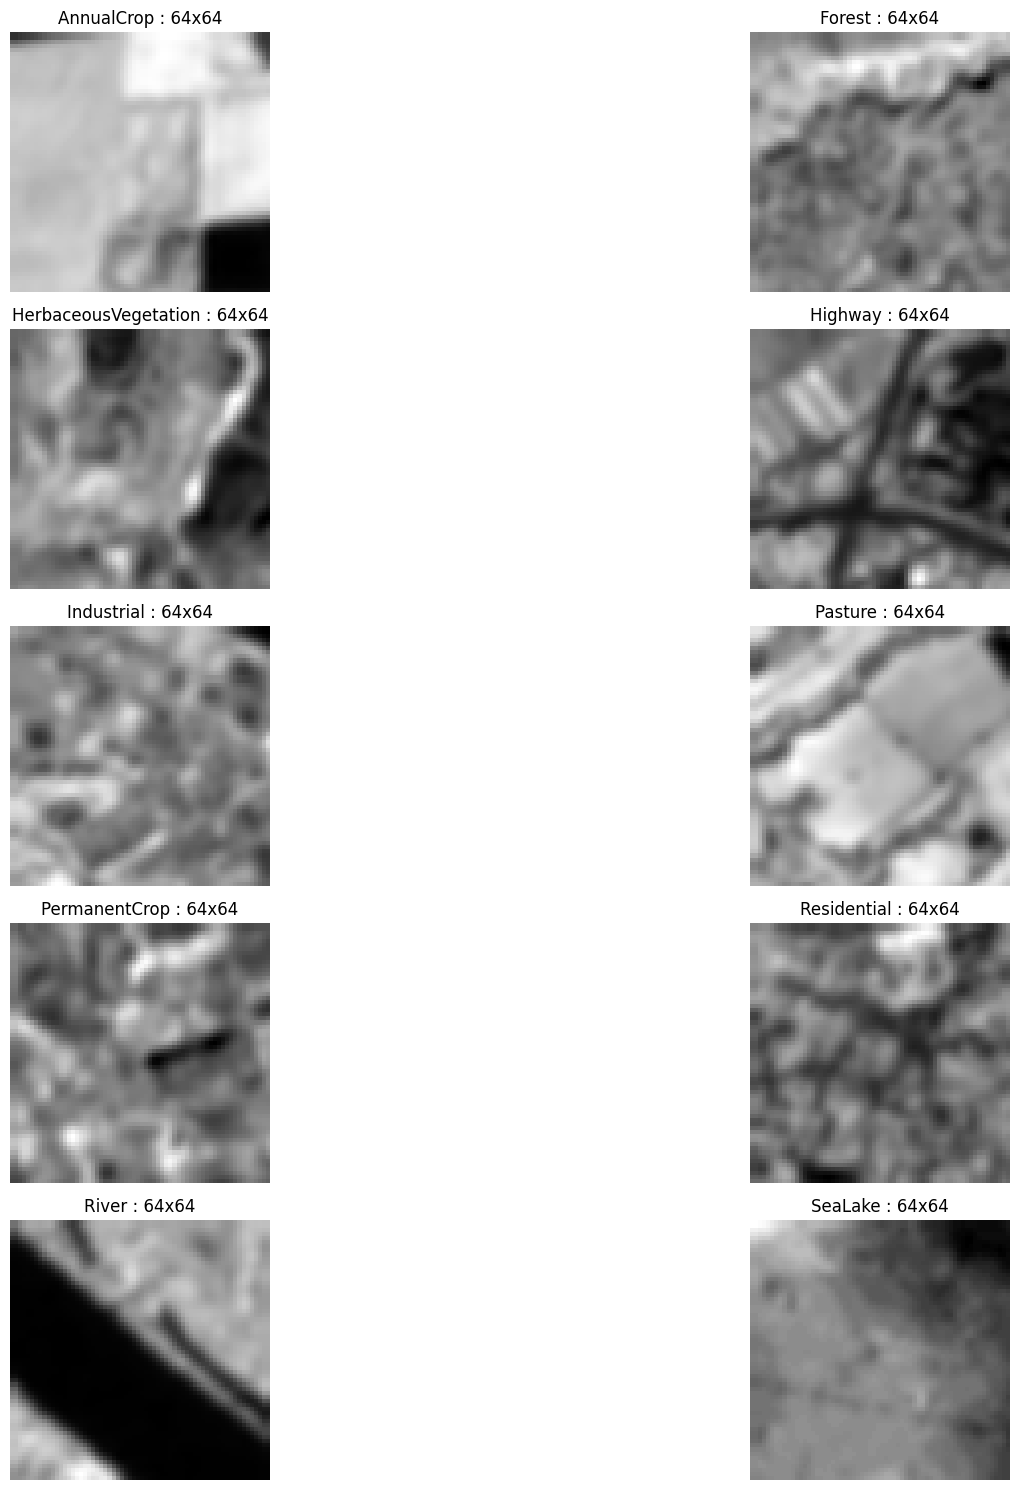

In [15]:
# plotting the image
import numpy as np
import rasterio
import matplotlib.pyplot as plt

categories = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 
              'PermanentCrop', 'Residential', 'River', 'SeaLake']

BASE_DIR = 'data/EuroSAT_MS'
img_num = np.random.randint(0, 3)

# # Load the TIFF image using rasterio
# file_path = f'data/original_images/train_{image_num}.tif'
# with rasterio.open(file_path) as dataset:
#     # Read the image data
#     img_data = dataset.read()
    
#     # Print metadata
#     print("Metadata:", dataset.meta)
    
#     # Dimensions
#     width, height = dataset.width, dataset.height
#     print(f"Size: {width}x{height}")

# Visualize each channel
fig, axes = plt.subplots(5, 2, figsize=(20, 15))  # Adjust subplot layout based on number of channels
axes = axes.flatten()
num_channels= 12
for i, cat in enumerate(categories):
    ax = axes[i]
    file_path = f'{BASE_DIR}/{cat}/{cat}_{img_num}.tif'
    with rasterio.open(file_path) as dataset:
        # Read the image data
        img_data = dataset.read()
        width, height = dataset.width, dataset.height
    ax.imshow(img_data[6], cmap='gray')
    ax.set_title(f'{cat} : {width}x{height}')
    ax.axis('off')

# Hide any unused subplots
for j in range(num_channels, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [5]:
import rasterio

p = 'data/3channel_images/train_39.tif'
arr = rasterio.open(p).read()
print(arr.shape)

(3, 802, 1288)
